In [1]:
import sys
sys.path.append('./lib')

import numpy as np
import optuna
import torch
import pickle

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

from ColorDataUtils.multidata_utils import MultiExperiment
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:1")
dtype = torch.float32

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


# load dataset

In [2]:
# load data
num_lags=16
expt_names = ['J220715','J220722','J220801','J220808']
expts = MultiExperiment(expt_names)
data, drift_terms, mu0s = expts.load(datadir,
                                     num_lags=num_lags,
                                     et_metric_thresh=0.8,
                                     array_types=['UT', 'UT', 'UT', 'UT'],
                                     luminance_only=True)

  FILE_INFO: stim_locsLP list again -- ok but output check
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  FILE_INFO: stim_locsLP list again -- ok but output check
630240 total time steps, 833 units
J220715 68.5% fixations remaining
J220722 64.8% fixations remaining
J220801 66.8% fixations remaining
J220808 48.2% fixations remaining
  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...


100%|█████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.72it/s]


  CROP: New stim size: 60 x 60
  Done: expt 0
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 49
  Writing lam stim 1: overlap 60, 51
  Writing lam stim 2: overlap 32, 51
  Writing lam stim 3: overlap 32, 49
  Writing ETstim 0: overlap 11, 51
  Writing ETstim 1: overlap 11, 48
  Adding fixation point
  Shifting stim...


100%|█████████████████████████████████████████████████| 24/24 [00:16<00:00,  1.48it/s]


  CROP: New stim size: 60 x 60
  Done: expt 1
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 52
  Writing lam stim 1: overlap 60, 48
  Writing lam stim 2: overlap 30, 48
  Writing lam stim 3: overlap 30, 52
  Writing ETstim 0: overlap 9, 48
  Writing ETstim 1: overlap 9, 50
  Adding fixation point
  Shifting stim...


100%|█████████████████████████████████████████████████| 36/36 [00:20<00:00,  1.74it/s]


  CROP: New stim size: 60 x 60
  Done: expt 2
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 57
  Writing lam stim 1: overlap 60, 43
  Writing lam stim 2: overlap 34, 43
  Writing lam stim 3: overlap 34, 57
  Writing ETstim 0: overlap 6, 42
  Writing ETstim 1: overlap 6, 57
  Adding fixation point
  Shifting stim...


100%|█████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.72it/s]


  CROP: New stim size: 60 x 60
  Done: expt 3
Stimulus assembly complete


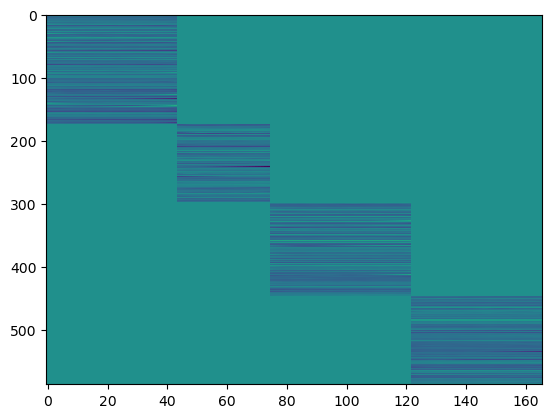

In [3]:
imagesc(drift_terms)

# adam params

In [19]:
class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn_model = ndn_model
        self.LLs = LLs
        self.trial = trial

adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW',
    batch_size=2, # * 240 timesteps
    num_workers=0,
    learning_rate=0.0017,
    early_stopping_patience=4,
    optimize_graph=False,
    weight_decay=0.235,
    max_epochs=1)
adam_parsT['device'] = device
#adam_parsT['accumulated_grad_batches'] = 6

# setup
data.device = device
NCv = data.NC
NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]

# model params

In [20]:
# some good starting parameters
Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5

folder_name = 'models/test_core'
num_trials = 10

# define model

In [21]:
def make_model(trial):
    LGNpars = STconvLayer.layer_dict(
        input_dims = data.stim_dims,
        num_filters=4,
        num_inh=2,
        bias=False,
        norm_type=1,
        filter_dims=[1,  # channels
                     7,  # width
                     7,  # height
                     14], # lags
        NLtype='relu',
        initialize_center=True)
    LGNpars['output_norm']='batch'
    LGNpars['window']='hamming'
    LGNpars['reg_vals'] = {'d2x':Xreg,
                           'd2t':Treg,
                           'center': Creg, # None
                           'edge_t':100} # just pushes the edge to be sharper
    
    num_subs = trial.suggest_int('num_subs', 10, 50)
    num_inh = trial.suggest_float('num_inh', 0.1, 0.7)
    proj_pars = ConvLayer.layer_dict(
        num_filters=num_subs,
        bias=False,
        norm_type=1,
        num_inh=int(num_inh*num_subs),
        filter_dims=trial.suggest_int('proj_filter_width', 7, 29, step=2),
        NLtype=trial.suggest_categorical('proj_NLtype', ['lin', 'relu']),
        initialize_center=True,
        pos_constraint=True)
    proj_pars['output_norm']='batch'
    proj_pars['window']='hamming'
    
    iter_layer = IterLayer.layer_dict(
        num_filters=num_subs,
        num_inh=int(num_inh*num_subs),
        bias=False,
        num_iter=trial.suggest_int('num_iter', 2, 8),
        output_config='full',
        pos_constraint=True,
        norm_type=1,
        filter_width=trial.suggest_int('iter_filter_width', 7, 47, step=2),
        num_lags=2,
        NLtype='relu',
        initialize_center=False,
        res_layer=False)
    iter_layer['output_norm'] = 'batch'
    
    scaffold_net =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold',
        xstim_n='stim',
        layer_list=[LGNpars, proj_pars, iter_layer],
        scaffold_levels=[1,2])
    
    ## 1: READOUT
    # reads out from a specific location in the scaffold network
    # this location is specified by the mus
    readout_pars = ReadoutLayer.layer_dict(
        num_filters=NCv,
        NLtype='lin',
        bias=False,
        pos_constraint=True)
    # for defining how to sample from the mu (location) of the receptive field
    readout_pars['gauss_type'] = 'isotropic'
    readout_pars['reg_vals'] = {'max': Mreg}
    
    readout_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[0],
        layer_list = [readout_pars],
        ffnet_type='readout')
    
    ## 2: DRIFT
    drift_pars = NDNLayer.layer_dict(
        input_dims=[1,1,1,NA],
        num_filters=NCv,
        bias=False,
        norm_type=0,
        NLtype='lin')
    drift_pars['reg_vals'] = {'d2t': Dreg}
    
    drift_net = FFnetwork.ffnet_dict(xstim_n = 'Xdrift', layer_list = [drift_pars])
    
    ## 3: COMB 
    comb_layer = ChannelLayer.layer_dict(
        num_filters=NCv,
        NLtype='softplus',
        bias=True)
    comb_layer['weights_initializer'] = 'ones'
    
    comb_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[1,2],
        layer_list=[comb_layer],
        ffnet_type='add')
    
    cnn = NDN.NDN(ffnet_list = [scaffold_net, readout_net, drift_net, comb_net],
                  loss_type='poisson')
    cnn.block_sample = True
    
    ## Network 1: readout: fixed mus / sigmas
    cnn.networks[1].layers[0].sample = False
    # mus and sigmas are the centers and "widths" of the receptive field center to start at
    cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn.networks[1].set_parameters(val=False, name='mu')
    cnn.networks[1].set_parameters(val=False, name='sigma')
    
    ## Network 2: drift: not fit
    cnn.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn.networks[2].set_parameters(val=False)
    
    ## Network 3: Comb
    cnn.networks[-1].set_parameters(val=False, name='weight')

    return cnn


def objective(trial):
    cnn = make_model(trial)

    cnn.fit(data, **adam_parsT, verbose=2)
    LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)

    null_adjusted_LLs = expts.LLsNULL-LLs

    cnn_model = Model(cnn, null_adjusted_LLs, trial)

    with open(folder_name+'/cnn_'+str(trial.number)+'.pkl', 'wb') as f:
        pickle.dump(cnn_model, f)

    # dump the intermediate study, but this will be off by one trial
    with open(folder_name+'/study.pkl', 'wb') as f:
        pickle.dump(study, f)

    return np.mean(null_adjusted_LLs)

# run study

In [22]:
from ColorDataUtils.model_validation import validate_model, MockTrial

val_map = {
    'iter_filter_width': 15,
    'num_inh': 0.69,
    'num_iter': 7,
    'num_subs': 45,
    'proj_NLtype': 'relu',
    'proj_filter_width': 15,
}

mock_trial = MockTrial(val_map)
model = make_model(mock_trial)

validate_model(model)

Model passed all checks


In [ ]:
# create study
study = optuna.create_study(direction='maximize',
                            study_name='Four datasets w/o initializing LGN weights')

# enqueue initial parameters
study.enqueue_trial(val_map)

# run the study
from cProfile import Profile
from pstats import SortKey, Stats

with Profile() as profile:
    print(f"{study.optimize(objective, n_trials=1) = }")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

# dump the final study
with open(folder_name+'/study.pkl', 'wb') as f:
    pickle.dump(study, f)

# print the best trial
print(study.best_trial.number, study.best_params)

[I 2023-08-16 18:23:41,695] A new study created in memory with name: Four datasets w/o initializing LGN weights


Model: M587_CsCX_R_N_A

GPU Available: True, GPU Used: True


Epoch 1:   1%|▎                    | 14/1050 [00:22<27:10,  1.57s/it, train_loss=0.13]


Done fitting
  Fit complete: 22.142834424972534 sec elapsed


Eval models:   0%|                                            | 0/106 [00:00<?, ?it/s]